<style type="text/css">
.time_spent {
    width: 3em;
    border-style: none;
    background-color: silver;
    font-weight: bold;
    padding-left: 5px;
}
</style>

# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control, SS17

# Assignment 3 - Eigenfaces and Line Fitting

Let us first setup this notebook so that figures and plots can be shown in it.

In [1]:
try:
    shell = get_ipython()
    shell.enable_pylab("inline")
except NameError:
    pass

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython
import PIL

**Hint**: Before you start solving the assignment, you might want to check the following *numpy* functions:

```
PIL.Image.open
scipy.misc.imresize
scipy.spatial.distance
numpy.linalg.eigh
```

## Eigenfaces

Eigenvectors have many applications which are not limited to obtaining surface normals from a set of point clouds. In this assignment, you are asked to write your own facial recognition library. Take a look at the following image:

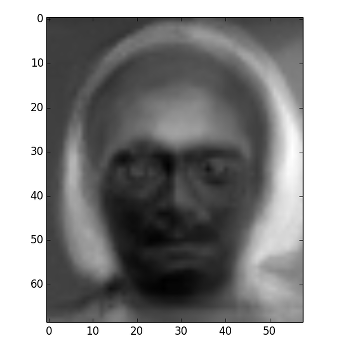

In [2]:
IPython.core.display.Image("images/ef0001.png")

This is what is called an *eigenface*. An eigenface really is nothing else than an eigenvector, in this case reshaped for plotting. Eigenfaces can be used in facial recognition, allowing a robot to distinguish between different persons, but can also be applied to other use cases, such as voice or gesture recognition.

**Your task consists of the following subtasks**:

1. Read the [Scholarpedia article](http://www.scholarpedia.org/article/Eigenfaces) about Eigenfaces.
2. Implement the eigenface algorithm described in the article. In particular, create a Python class that exposes (at least) two methods:
    1. A method for calculating eigenfaces given two parameters, namely (i) a set of images and (ii) subject ids that uniquely identify the subjects in the images.
    2. A method that takes one parameter - a list of query faces - and, for each face in the input list, finds the subject id of the most similar face. This method should thus return a list of subject ids.

A dataset for training your recognition algorithm is given in the *data/training* folder. The images in the *data/test* folder should be used for testing the algorithm.

For your implementation, please use the method signatures given below. Use the code under **Testing your code** for loading the images and testing your implementation.

**Hint:** You might want to investigate how Principal Component Analysis (PCA) works.

In [3]:
class FaceRecognition(object):
    def __init__(self):
        self.subject_ids = None
        self.faces = None
        self.eigenface_weights = None
        self.mean_image = None

    def eigenfaces(self, image_filenames, subject_ids):
        '''Finds a set of eigenfaces based on the input images.

        Keyword arguments:
        image_filenames -- A list of image filenames
        subject_ids -- A list of IDs that uniquely identify the subjects
                       in the images

        '''
        self.subject_ids = np.array(subject_ids)
        number_of_images = len(image_filenames)

        #we will transform each image to a row vector
        #of size 69 x 58, which gives 4002 pixels per image
        images = np.zeros((number_of_images, 4002))

        #we read each image file, resize the image to
        #size 69 x 58, and append the rows together
        for i in range(number_of_images):
            image = PIL.Image.open(image_filenames[i])
            image = image.resize((69, 58))
            images[i] = np.array(image).flatten()

        #we transpose the images because we want to have
        #each image as a column
        images = images.T

        #we find the mean image and convert it to a column vector
        self.mean_image = np.mean(images, axis=1)[np.newaxis].T

        #we subtract the mean image from each image
        #and transpose the matrix of mean-subtracted images
        mean_differences = images - self.mean_image

        #we calculate the product
        #
        # M = MSIT x MSI,
        #
        #where MSI is the matrix of mean subtracted images and
        #MSIT is its transpose; we then calculate
        #the eigenvalues and eigenvectors of M
        #and find the eigenvectors of the covariance matrix S, given as
        #
        # S = mean subtracted images x mean subtracted images transposed
        #
        #as the product
        #
        # eigenvectors(S) = MSI x eigenvectors(M)
        #
        temp_product = np.dot(mean_differences.T, mean_differences)
        _, temp_eigenvectors = linalg.eig(temp_product)
        eigenvectors = mean_differences.dot(temp_eigenvectors)

        #we normalize the eigenvectors
        self.faces = np.divide(eigenvectors,
                np.sqrt(np.sum(eigenvectors**2, axis=0)))

        #we calculate weight vectors for the training images
        self.eigenface_weights = self.faces.T.dot(mean_differences)

    def recognize_faces(self, image_filenames):
        '''Finds the eigenfaces that have the highest
        similarity to the input images.

        Keyword arguments:
        image_filenames -- A list of image filenames

        Returns:
        recognised_ids -- A list of ids that correspond to the classifier
                          predictions for the input images

        '''
        number_of_images = len(image_filenames)
        recognised_ids = np.zeros(number_of_images, dtype=int)
        for i in range(number_of_images):
            image = PIL.Image.open(image_filenames[i])
            face = np.array(image.resize((69, 58))).flatten()[np.newaxis].T

            #we find the weight vector that corresponds to the test image
            mean_difference = face - self.mean_image
            weights = self.faces.T.dot(mean_difference)

            #we calculate the distance from the weight vector of the test image
            #to the weight vectors of the training images and return the index
            #of the training image to which the distance is the smallest
            distances = numpy.sqrt(np.sum((self.eigenface_weights - weights)**2,
                                             axis=0))
            recognised_ids[i] = self.subject_ids[np.argmin(distances)]
        return recognised_ids

# Testing your code

In [4]:
import os
import glob

#loading training images
training_image_filenames = sorted(glob.iglob('data/training/*.pgm'))

#loading test images
test_image_filenames = sorted(glob.iglob('data/test/*.pgm'))

#creating a lambda function for extracting filenames;
#the filename of each image is the subject id
subject_number = lambda filename: int(os.path.basename(filename)[7:9])

#extracting the filename using the lambda function
train_subject_ids = list (map(subject_number, training_image_filenames))
test_subject_ids = list (map(subject_number, test_image_filenames))

print 'Test subject ids:', np.array(test_subject_ids)

face_recognition = FaceRecognition()
face_recognition.eigenfaces(training_image_filenames, train_subject_ids)
recognized_ids = face_recognition.recognize_faces(test_image_filenames)
print 'Predicted subject ids:', recognized_ids

different_results = np.array(test_subject_ids) - np.array(recognized_ids)
positives = (different_results == 0).sum()
accuracy = positives / (len(test_subject_ids) * 1.)
print 'Number of correct predictions =', positives
print 'Prediction accuracy =', accuracy

Test subject ids: [ 1  1  1  1  2  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  6  7  7  7  7
  8  8  8  9  9  9  9  9 10 10 10 11 11 11 11 11 12 12 12 13 13 14 14 14 14
 15 15 15 15 15]
Predicted subject ids: [10  1  2  1  2  3  3 14  4  4 14  4  5  5  9  5  6  6  2  6  6  7  7  7  7
  8  2  8  9  9  9  9  9 10 10 10 11 11 11 11 11 12 12 12 13 13 14 14  4 14
 15  3 15 15 15]
Number of correct predictions = 46
Prediction accuracy = 0.836363636364


## Line fitting

Assume that our robot captures the following point cloud using its Kinect sensor:

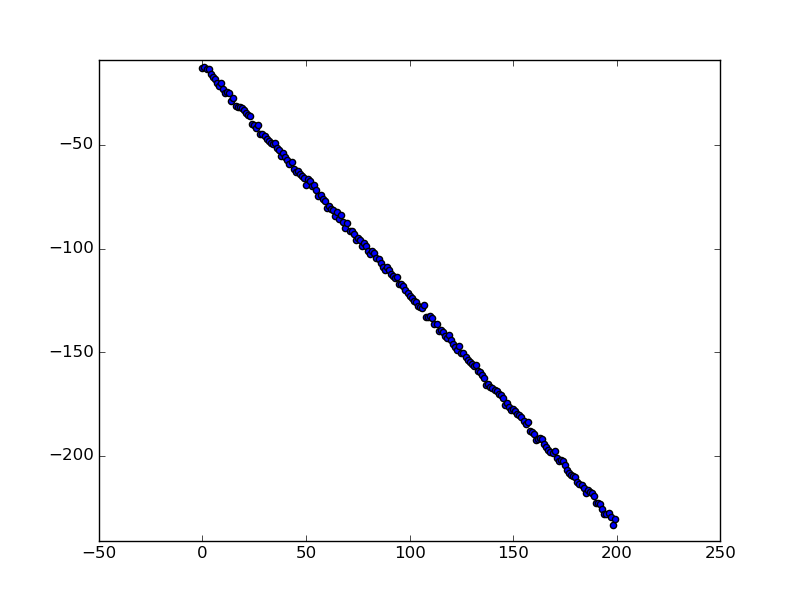

In [5]:
IPython.core.display.Image("images/points.png", embed=True)

Your task is to fit a line to the captured point cloud. The individual points of the point cloud are given in the file *data/points.npy*.

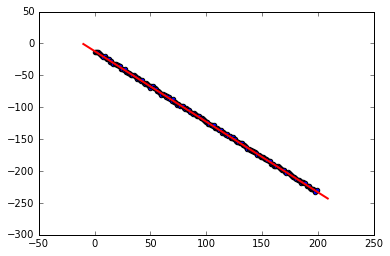

In [6]:
def line_fit(data):
    # creating the matrix A
    A = np.hstack((data[:,0][np.newaxis].T, np.ones((data.shape[0], 1))))

    # creating the right-hand side vector b
    b = data[:,1][np.newaxis].T

    # finding the pseudo-inverse of A
    U, s, Vt = np.linalg.svd(A)

    s_inv = np.array(s)
    for i in xrange(len(s_inv)):
        if abs(s_inv[i] - 0.) > 1e-5:
            s_inv[i] = 1. / s_inv[i]
    S_inv = np.zeros((Vt.shape[0], U.shape[1]))
    np.fill_diagonal(S_inv, s_inv)

    A_pinv = Vt.T.dot(S_inv).dot(U.T)

    # we can now solve the system using A's pseudo-inverse
    X = A_pinv.dot(b)

    # instead of calculating the pseudo-inverse manually,
    # we could simply use
    #     X = np.linalg.pinv(A).dot(B)
    # but we don't want to be lazy in this course

    m = X[0]
    c = X[1]
    return m, c

data = np.load('data/points.npy')
m, c = line_fit(data)
x = np.linspace(np.min(data[:,0]) - 10, np.max(data[:,0]) + 10, 1000)
y = m * x + c

plt.scatter(data[:,0], data[:,1])
plt.plot(x, y, color='r', linewidth=2)
plt.show()